# Projet 6 - Etude de faisabilité de la classification en utilisant des méthodes de traitement d'images basiques

## Préparation du dataset

In [1]:
#imports divers

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
import time
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np



In [2]:
#import du fichier dans un dataframe pandas
data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
#etude des colonnes du dataset
data.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [4]:
# visualisation des colonnes intéressantes
data[['product_category_tree', 'image']]

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",fd6cbcc22efb6b761bd564c28928483c.jpg
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",5912e037d12774bb73a2048f35a00009.jpg
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


In [5]:
# extraction de la catégorie du produit
data['label_name'] = data['product_category_tree'].str.extract(r'\[\"(.*?)>>', expand=False)

In [6]:
#compte du nombre de modalités et effectifs correspondant
data['label_name'].value_counts()

label_name
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

In [7]:
#variante 
data.groupby("label_name").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
label_name,,,,,,,,,,,,,,,
Baby Care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150
Beauty and Personal Care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150
Computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Home Decor & Festive Needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149
Home Furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Kitchen & Dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150
Watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150


In [8]:
#sélection des colonnes intéressantes
data = data[['product_name', 'image', 'description', 'label_name']].copy()

In [9]:
data

,product_name,image,description,label_name
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care


## Encodage label

In [10]:
# Encoder les labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label_name'])

# Afficher les correspondances des valeurs
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Correspondance des valeurs :")
print(label_mapping)

list_labels = label_encoder.classes_

Correspondance des valeurs :
{'Baby Care ': 0, 'Beauty and Personal Care ': 1, 'Computers ': 2, 'Home Decor & Festive Needs ': 3, 'Home Furnishing ': 4, 'Kitchen & Dining ': 5, 'Watches ': 6}


In [11]:
list_labels

array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

### Affichage exemples images


Baby Care 


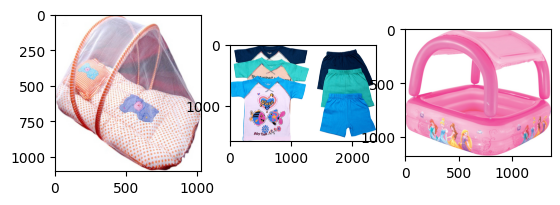

Beauty and Personal Care 


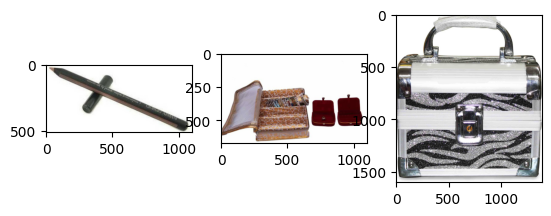

Computers 


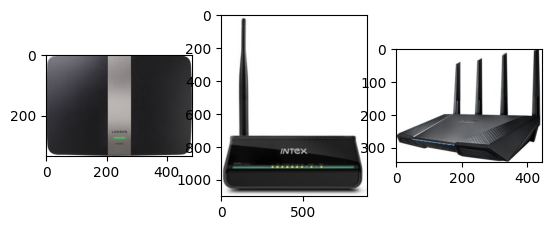

Home Decor & Festive Needs 


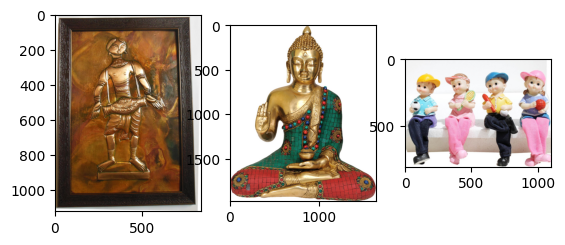

Home Furnishing 


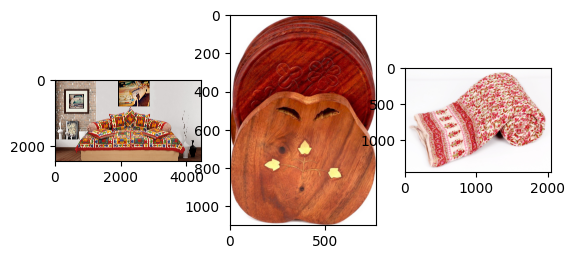

Kitchen & Dining 


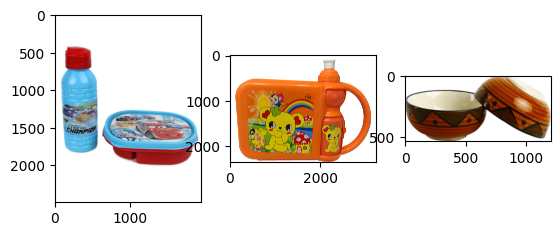

Watches 


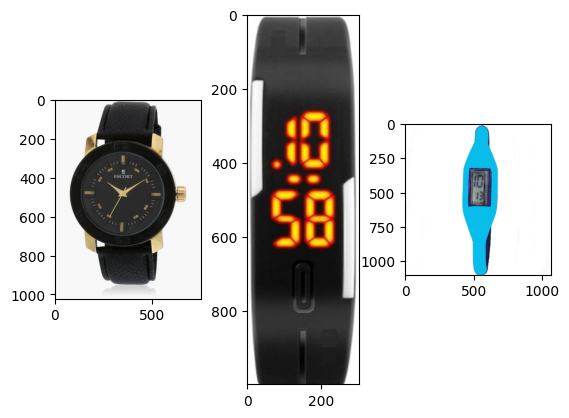

In [12]:
from matplotlib.image import imread

path = "data/Images/"
list_photos = data["image"]

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

list_baby_care=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Baby Care "]
list_beauty_and_personal_care=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Beauty and Personal Care "]
list_computers=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Computers "]
list_home_decor_and_festive_needs=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Home Decor & Festive Needs "]
list_home_furnishing=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Home Furnishing "]
list_kitchen_and_dining=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Kitchen & Dining "]
list_watches=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Watches"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

* L'image contient 3526 descripteurs
* Chaque descripteur est un vecteur de longueur 128

[ WARN:0@0.030] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


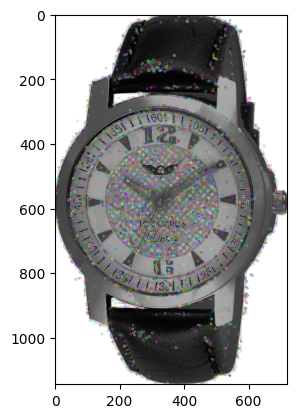

Descripteurs :  (3526, 128)

[[ 0.  0.  0. ...  0.  1.  5.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  4.]
 ...
 [ 2.  0.  0. ... 15. 81. 43.]
 [15. 32.  3. ...  0.  0. 40.]
 [22. 49.  0. ...  1. 14. 16.]]


In [13]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[12],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [14]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)
i = 0

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    #print(path+list_photos[image_num])
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

# Filtrer les descripteurs `None` et convertir en tableau NumPy
sift_keypoints = [des for des in sift_keypoints if des is not None]

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517350, 128)
temps de traitement SIFT descriptor :           350.37 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [15]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             2.25 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [16]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             0.91 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [17]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 501)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [18]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)


(1050, 3)


In [19]:
df_tsne

,tsne1,tsne2,class
0,13.821884,-23.126072,Home Furnishing
1,-7.202524,-15.358940,Baby Care
2,-17.655159,0.652018,Baby Care
3,-2.974661,-20.442604,Home Furnishing
4,-5.658563,-14.417380,Home Furnishing
...,...,...,...
1045,-27.766310,3.813107,Baby Care
1046,-13.665653,0.861443,Baby Care
1047,7.685104,-14.507646,Baby Care
1048,22.888321,32.468647,Baby Care


## Analyse visuelle : affichage T-SNE selon catégories d'images


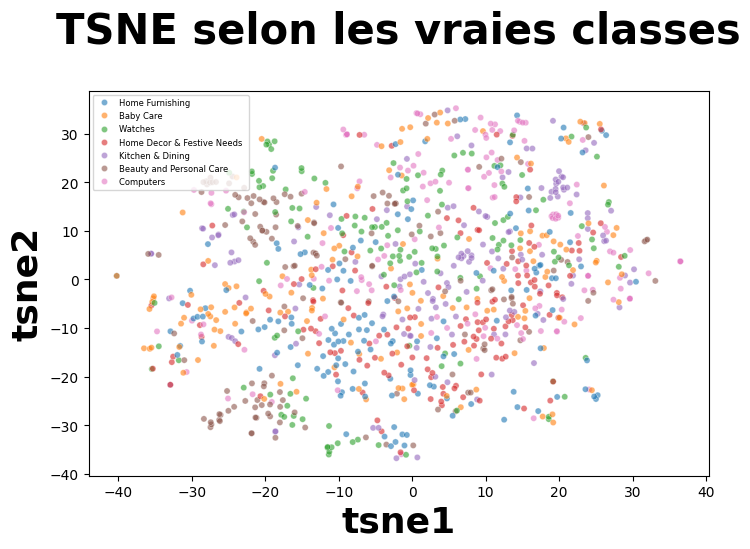

In [20]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=20, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [21]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.03 est très faible

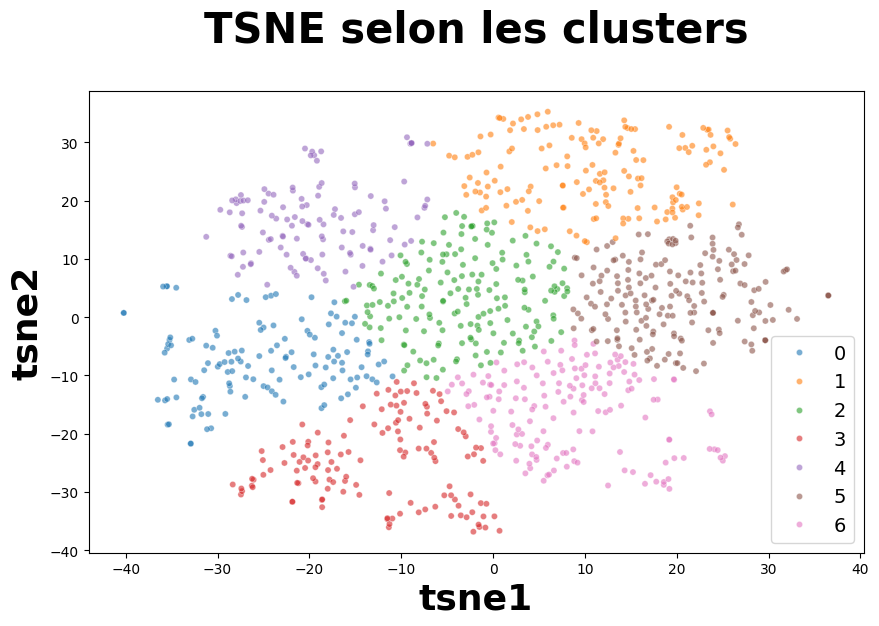

ARI :  0.03950075883707269


In [22]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=20, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne


In [23]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    131
1    155
2    174
3    134
4    113
5    183
6    160
Name: class, dtype: int64

In [24]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[41 20 18 13  9 27 22]
 [10  8 27 37 41 16 11]
 [11 48 15  5 15 38 18]
 [22  8 17 16  3 32 52]
 [22 15 25 35  6 19 28]
 [16 34 35  6 12 28 19]
 [ 9 22 37 22 27 23 10]]


In [25]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)

    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 2 6 1 1 2 3]
[[41 22 47 22  0  0 18]
 [10 78 24 11  0  0 27]
 [11 20 86 18  0  0 15]
 [22 19 40 52  0  0 17]
 [22 41 34 28  0  0 25]
 [16 18 62 19  0  0 35]
 [ 9 49 45 10  0  0 37]]

              precision    recall  f1-score   support

           0       0.31      0.27      0.29       150
           1       0.32      0.52      0.39       150
           2       0.25      0.57      0.35       150
           3       0.33      0.35      0.34       150
           4       0.00      0.00      0.00       150
           5       0.00      0.00      0.00       150
           6       0.21      0.25      0.23       150

    accuracy                           0.28      1050
   macro avg       0.20      0.28      0.23      1050
weighted avg       0.20      0.28      0.23      1050



/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Axes: >

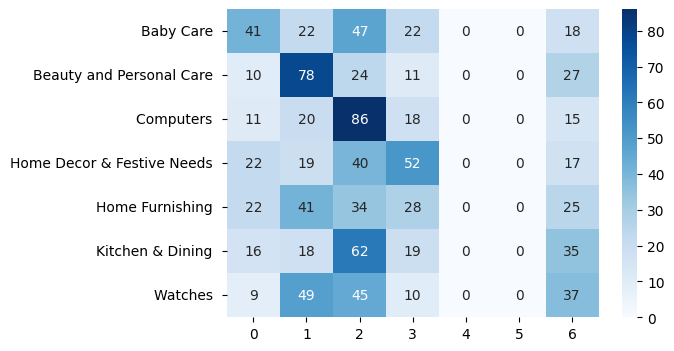

In [26]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")